# Script to analyse qPCR data
- Created 2025-03-24 by RET

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import argparse
import pathlib

In [178]:
# Set seaborn theme and other plotting related parameters
sns.set_theme(style="whitegrid", palette="Paired")

### Read in data file
#### Data file has the format:

| Sample Name | Gene Name | Condition Name | Cq | Cq_mean | Cq Error |

**-> Data file should have only one page**

In [179]:
# Data file path (.xlsx file)
data_file_path = ""

# Read in data file
data_file = pd.read_excel(data_file_path)
data_file

# Output folder, for plots and results table
output_fld = ""

In [180]:
# Somtimes there are white spaces in the column names or the columns themselves
# These will be removed with the following function

def strip_emty_spaces_from_sheet(input_data, column_w_gene_names='Gene Name', column_w_sample_names='Sample Name'):
    """Strips empty spaces in front and at the end of strings for certain columns and the headers"""

    input_data.rename(columns=lambda x: x.strip(), inplace=True) # Strips empty spaces from column names
    input_data[column_w_gene_names] = input_data[column_w_gene_names].apply(lambda x: x.strip()) # Strips empty spaces from gene column
    input_data[column_w_sample_names] = input_data[column_w_sample_names].apply(lambda x: x.strip()) # Strips empty spaces from condition column
    
    return input_data

In [181]:
# Strip extra white spaces from data sheet
data_file = strip_emty_spaces_from_sheet(data_file)

In [182]:
# Filter data frame to remove rows that contain dashes

for df_column in ['Cq', 'Cq Mean', 'Cq Error']:
    df_remove_dashes[df_column] = pd.to_numeric(data_file[df_column], errors='coerce')
    

In [183]:
# Calculate delta Cq and ratio values and save them in an excel file called qPCR_out_TEST.xlsx

# Define housekeeping gene
housekeeping_gene = 'GAPDH'

# Go through all samples
for sample in df_remove_dashes['Sample Name']:
    # Go through all genes
    for gene in df_remove_dashes['Gene Name'].unique():
        # To calculate the Cq value look up if the gene is not the housekeeping gene, then find the cq value of this
        # sample + gene combination and subtract the Cq value of the housekeeping gene with the same condition name
        # Then calculate the ratio from the delta Cq value and save everything in a new excel sheet
        if gene != housekeeping_gene and df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Cq'].values.size == 3:

            delta_Cq = df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Cq'].values - df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == housekeeping_gene), 'Cq Mean'].values
            ratio = 2**(-delta_Cq)

            delta_Cq_mean = df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Cq Mean'].values - df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == housekeeping_gene), 'Cq Mean'].values
            ratio_mean = 2**(-delta_Cq_mean)
            
            if delta_Cq.size > 0:
                df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Delta Cq'] = delta_Cq
                df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Ratio'] = ratio

                df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Delta Cq Mean'] = delta_Cq_mean
                df_remove_dashes.loc[(df_remove_dashes['Sample Name'] == sample) & (df_remove_dashes['Gene Name'] == gene), 'Ratio Mean'] = ratio_mean
                
df_remove_dashes.to_excel(output_fld+'qPCR_out.xlsx')


In [184]:
# Create color palette, gray=Control, red=Inhibitors, blue=Activators
color_palette = ['#777779','#5b0000', '#1063b4', '#6095ec', '#00b1c9']

# Set order of conditions for plotting
condition_order = ['WTCwt DMSO 10µM NO MAT', 'WTCwt TED-34 10µM NO MAT', 'WTCwt Truli-37 10µM NO MAT', 'WTCwt GA-017 10µM NO MAT', 'WTCwt Py-60 10µM NO MAT']


In [185]:
# Subset to no matrigel conditions
df_nomat_conditions = df_remove_dashes[df_remove_dashes['Condition Name'] == 'NoMat']

# Subset to 10µM conditions
df_10_condtions = df_nomat_conditions[df_nomat_conditions['Sample Name'].str.contains('10', case=False, na=False)]


In [186]:
def make_qPCR_gene_plots(dataset, gene_to_plot, conditions, color_pal):
    """Plot relative gene expression from qPCR data"""
    
    ratio_qPCR_all_conditions = sns.catplot(
        data=dataset[dataset['Gene Name'] == gene_to_plot], kind="bar",
        x='Sample Name', y='Ratio', hue='Sample Name', order=conditions, hue_order=conditions,
        errorbar="sd", palette=color_pal, alpha=0.75, height=10, aspect=0.5
    )
    
    sns.swarmplot(data=dataset[dataset['Gene Name'] == gene_to_plot], x='Sample Name', y='Ratio', hue='Sample Name', dodge=False, legend=True, palette=color_pal, hue_order=conditions)
    
    plt.ylim(0, 0.4)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.ylabel('Relative gene expression [2^(-∆Ct)]')
    plt.title(f'Relative {gene_to_plot} expression', fontsize=20)
    plt.tight_layout()
    plt.savefig(f'{output_fld}/Morphodynamics{gene_to_plot}_RATIO.pdf')

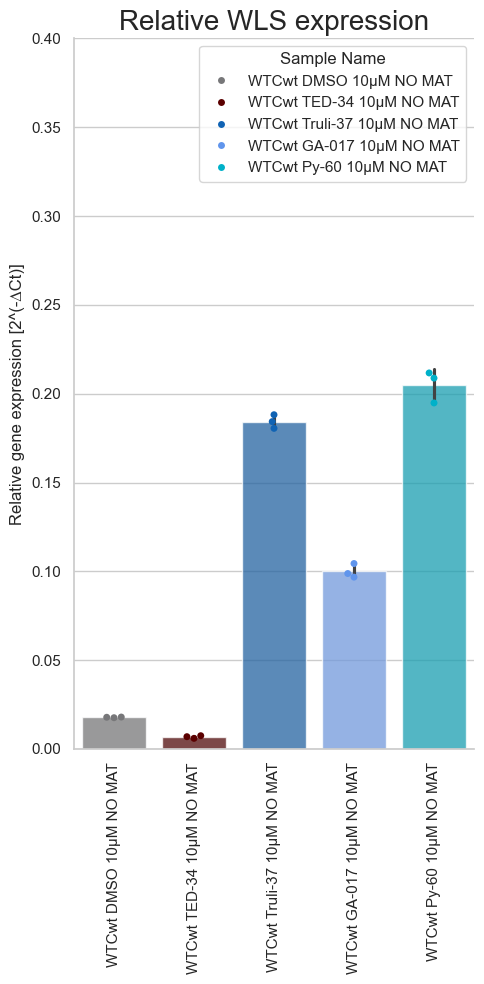

In [187]:
make_qPCR_gene_plots(df_10_condtions, gene_to_plot='WLS', conditions=condition_order, color_pal=color_palette)